In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
    
    
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1 + residual_2 + residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in range(nIter):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 10*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
set_seed(0) #设置随机数种子
seeds = [random.randint(0, 100000) for _ in range(200)]
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']

N_u = 1
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([60000.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)

        #计算信息量
        xinxi = abs_residual

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    up = 80000
    n_star = 5000+1
    x_star = np.linspace(lb, up, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 50)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Training time: 125.5288
当前为第1次循环，种子为73807
Error y : 4.814073e-02
MAE: 2.284289e-02
MSE: 9.133390e-04
Chaos: 1.216672e+02
Residual: 3.406319e-08


Training time: 125.1117
当前为第2次循环，种子为27045
Error y : 5.048270e-02
MAE: 2.626649e-02
MSE: 1.094472e-03
Chaos: 2.765967e-03
Residual: 3.403750e-08


Training time: 124.1516
当前为第3次循环，种子为26134
Error y : 4.346767e-02
MAE: 2.321181e-02
MSE: 8.514311e-04
Chaos: 3.089455e+03
Residual: 3.149080e-08


Training time: 125.1719
当前为第4次循环，种子为99239
Error y : 4.215738e-02
MAE: 2.139458e-02
MSE: 7.571098e-04
Chaos: 9.376304e+03
Residual: 3.198653e-08


Training time: 144.0184
当前为第5次循环，种子为43964
Error y : 5.194030e-02
MAE: 2.514991e-02
MSE: 1.179454e-03
Chaos: 3.960760e-03
Residual: 3.592299e-08


Training time: 194.3289
当前为第6次循环，种子为36402
Error y : 4.511406e-02
MAE: 2.387576e-02
MSE: 8.920097e-04
Chaos: 8.285835e+00
Residual: 3.263358e-08


Training time: 200.6280
当前为第7次循环，种子为81961
Error y : 6.350813e-02
MAE: 2.979720e-02
MSE: 1.358023e-03
Chaos: 1.939568e+04
Residual: 2.630259e-08


Training time: 199.3493
当前为第8次循环，种子为91424
Error y : 4.833664e-02
MAE: 2.381537e-02
MSE: 9.882287e-04
Chaos: 9.457398e+03
Residual: 3.602554e-08


Training time: 202.5959
当前为第9次循环，种子为62504
Error y : 4.102440e-02
MAE: 2.123112e-02
MSE: 7.462564e-04
Chaos: 7.270306e-01
Residual: 3.098637e-08


Training time: 201.8874
当前为第10次循环，种子为67531
Error y : 4.640670e-02
MAE: 2.252192e-02
MSE: 8.812057e-04
Chaos: 1.768821e-03
Residual: 3.474383e-08


Training time: 200.7657
当前为第11次循环，种子为38210
Error y : 5.448748e-02
MAE: 2.825878e-02
MSE: 1.252585e-03
Chaos: 1.569219e-03
Residual: 3.457285e-08


Training time: 200.7741
当前为第12次循环，种子为10371
Error y : 7.135241e-02
MAE: 3.172656e-02
MSE: 1.577235e-03
Chaos: 3.496714e+03
Residual: 2.767649e-08


Training time: 202.8903
当前为第13次循环，种子为66191
Error y : 6.088488e-02
MAE: 2.943628e-02
MSE: 1.342783e-03
Chaos: 1.058629e-03
Residual: 2.995432e-08


Training time: 204.6261
当前为第14次循环，种子为86450
Error y : 4.919798e-02
MAE: 2.274686e-02
MSE: 9.859928e-04
Chaos: 1.663236e-03
Residual: 3.312039e-08


Training time: 203.3376
当前为第15次循环，种子为38626
Error y : 4.318191e-02
MAE: 2.170193e-02
MSE: 7.861732e-04
Chaos: 9.267396e-01
Residual: 3.191803e-08


Training time: 204.3282
当前为第16次循环，种子为68928
Error y : 5.541866e-02
MAE: 2.707792e-02
MSE: 1.257333e-03
Chaos: 2.022344e+00
Residual: 3.382661e-08


Training time: 200.9410
当前为第17次循环，种子为42994
Error y : 5.024448e-02
MAE: 2.206621e-02
MSE: 9.410583e-04
Chaos: 3.947559e-01
Residual: 3.553441e-08


Training time: 204.5001
当前为第18次循环，种子为63353
Error y : 5.626814e-02
MAE: 2.626580e-02
MSE: 1.155218e-03
Chaos: 2.734859e-03
Residual: 3.015066e-08


Training time: 204.2995
当前为第19次循环，种子为96068
Error y : 5.232502e-02
MAE: 2.641199e-02
MSE: 1.081322e-03
Chaos: 3.223526e+01
Residual: 3.111631e-08


Training time: 202.2067
当前为第20次循环，种子为2160
Error y : 6.161030e-02
MAE: 2.816679e-02
MSE: 1.254179e-03
Chaos: 4.179978e+00
Residual: 2.777745e-08


Training time: 163.7303
当前为第21次循环，种子为49462
Error y : 4.838823e-02
MAE: 2.415591e-02
MSE: 1.018591e-03
Chaos: 1.686785e+02
Residual: 3.393188e-08


Training time: 133.3949
当前为第22次循环，种子为27095
Error y : 7.056755e-02
MAE: 3.122118e-02
MSE: 1.621201e-03
Chaos: 3.864121e-01
Residual: 3.015339e-08


Training time: 133.7626
当前为第23次循环，种子为58412
Error y : 4.716791e-02
MAE: 2.366349e-02
MSE: 9.408050e-04
Chaos: 6.371605e-03
Residual: 3.098398e-08


Training time: 132.3549
当前为第24次循环，种子为23261
Error y : 5.081801e-02
MAE: 2.527162e-02
MSE: 9.914867e-04
Chaos: 2.459368e+01
Residual: 2.999514e-08


Training time: 133.4680
当前为第25次循环，种子为34480
Error y : 5.069078e-02
MAE: 2.553028e-02
MSE: 1.124934e-03
Chaos: 9.074107e+02
Residual: 3.207811e-08


Training time: 134.0400
当前为第26次循环，种子为88210
Error y : 5.447692e-02
MAE: 2.752989e-02
MSE: 1.312592e-03
Chaos: 2.395896e+04
Residual: 3.543687e-08


Training time: 132.3934
当前为第27次循环，种子为53399
Error y : 4.246175e-02
MAE: 1.804407e-02
MSE: 6.550358e-04
Chaos: 1.584853e-03
Residual: 3.875209e-08


Training time: 132.1683
当前为第28次循环，种子为5335
Error y : 5.314942e-02
MAE: 2.571956e-02
MSE: 1.201198e-03
Chaos: 3.000814e+03
Residual: 3.589548e-08


Training time: 133.4493
当前为第29次循环，种子为19217
Error y : 5.507495e-02
MAE: 2.655844e-02
MSE: 1.320396e-03
Chaos: 2.585314e+04
Residual: 3.770674e-08


Training time: 133.7561
当前为第30次循环，种子为29094
Error y : 4.643041e-02
MAE: 2.430375e-02
MSE: 9.838502e-04
Chaos: 1.174245e+00
Residual: 3.503965e-08


Training time: 132.6018
当前为第31次循环，种子为60487
Error y : 4.773632e-02
MAE: 2.266131e-02
MSE: 8.971644e-04
Chaos: 1.166155e+00
Residual: 3.430227e-08


Training time: 130.7191
当前为第32次循环，种子为54506
Error y : 4.805579e-02
MAE: 2.293721e-02
MSE: 9.573128e-04
Chaos: 2.255916e-03
Residual: 3.125137e-08


Training time: 133.0825
当前为第33次循环，种子为29280
Error y : 4.362522e-02
MAE: 2.192373e-02
MSE: 8.457199e-04
Chaos: 3.081026e-03
Residual: 3.272385e-08


Training time: 132.4375
当前为第34次循环，种子为63623
Error y : 5.125557e-02
MAE: 2.459255e-02
MSE: 1.114867e-03
Chaos: 5.567293e+00
Residual: 3.465448e-08


Training time: 133.1325
当前为第35次循环，种子为75510
Error y : 4.431874e-02
MAE: 2.335659e-02
MSE: 8.641170e-04
Chaos: 2.620519e+02
Residual: 3.277842e-08


Training time: 134.3481
当前为第36次循环，种子为9244
Error y : 5.070460e-02
MAE: 2.624875e-02
MSE: 1.124554e-03
Chaos: 3.897867e-02
Residual: 3.490618e-08


Training time: 123.7482
当前为第37次循环，种子为28015
Error y : 4.895848e-02
MAE: 2.496323e-02
MSE: 9.890441e-04
Chaos: 2.806757e-01
Residual: 3.352523e-08


Training time: 124.0967
当前为第38次循环，种子为7330
Error y : 4.588359e-02
MAE: 2.268708e-02
MSE: 8.898027e-04
Chaos: 1.623519e-03
Residual: 3.249693e-08


Training time: 124.6759
当前为第39次循环，种子为7369
Error y : 4.903008e-02
MAE: 2.249815e-02
MSE: 9.374493e-04
Chaos: 7.530540e+02
Residual: 3.622790e-08


Training time: 124.6889
当前为第40次循环，种子为25697
Error y : 4.673675e-02
MAE: 2.413558e-02
MSE: 9.463576e-04
Chaos: 8.462340e+02
Residual: 3.285891e-08


Training time: 125.1272
当前为第41次循环，种子为67558
Error y : 4.486779e-02
MAE: 2.188776e-02
MSE: 8.328963e-04
Chaos: 1.437218e-03
Residual: 3.456660e-08


Training time: 124.8572
当前为第42次循环，种子为14125
Error y : 4.861020e-02
MAE: 2.376037e-02
MSE: 1.014412e-03
Chaos: 8.734121e+02
Residual: 3.416289e-08


Training time: 124.2000
当前为第43次循环，种子为20431
Error y : 5.415967e-02
MAE: 2.627758e-02
MSE: 1.104171e-03
Chaos: 3.155075e+03
Residual: 3.007790e-08


Training time: 124.1947
当前为第44次循环，种子为34830
Error y : 5.567697e-02
MAE: 2.720941e-02
MSE: 1.237967e-03
Chaos: 3.244649e+00
Residual: 3.421997e-08


Training time: 124.0982
当前为第45次循环，种子为55842
Error y : 5.199415e-02
MAE: 2.511166e-02
MSE: 9.670125e-04
Chaos: 3.253445e+04
Residual: 3.056329e-08


Training time: 123.2637
当前为第46次循环，种子为61554
Error y : 6.594427e-02
MAE: 3.052779e-02
MSE: 1.434468e-03
Chaos: 3.272586e+00
Residual: 2.940385e-08


Training time: 124.3930
当前为第47次循环，种子为18734
Error y : 5.169600e-02
MAE: 2.660420e-02
MSE: 1.155609e-03
Chaos: 1.467418e-03
Residual: 3.411537e-08


Training time: 124.2973
当前为第48次循环，种子为55222
Error y : 5.523771e-02
MAE: 2.887462e-02
MSE: 1.303545e-03
Chaos: 8.118439e-01
Residual: 3.295554e-08


Training time: 124.3788
当前为第49次循环，种子为4751
Error y : 4.778977e-02
MAE: 2.127810e-02
MSE: 8.742968e-04
Chaos: 7.296678e+01
Residual: 3.295395e-08


Training time: 123.6380
当前为第50次循环，种子为5211
Error y : 1.007925e-01
MAE: 4.116350e-02
MSE: 2.874037e-03
Chaos: 4.335915e-02
Residual: 2.665627e-08


Training time: 124.2979
当前为第51次循环，种子为93405
Error y : 5.397619e-02
MAE: 2.605881e-02
MSE: 1.255425e-03
Chaos: 4.677976e+04
Residual: 3.526270e-08


Training time: 124.6069
当前为第52次循环，种子为11364
Error y : 6.808023e-02
MAE: 3.066034e-02
MSE: 1.526206e-03
Chaos: 1.248322e+01
Residual: 2.829665e-08


Training time: 124.4588
当前为第53次循环，种子为78341
Error y : 4.636627e-02
MAE: 2.389388e-02
MSE: 8.842882e-04
Chaos: 8.557127e+01
Residual: 3.190667e-08


Training time: 124.6169
当前为第54次循环，种子为83306
Error y : 4.655742e-02
MAE: 2.167387e-02
MSE: 8.755842e-04
Chaos: 1.054671e+02
Residual: 3.818172e-08


Training time: 123.2076
当前为第55次循环，种子为7410
Error y : 4.526074e-02
MAE: 2.375193e-02
MSE: 9.161814e-04
Chaos: 4.481789e+02
Residual: 3.380228e-08


Training time: 124.3155
当前为第56次循环，种子为4654
Error y : 5.004824e-02
MAE: 2.596094e-02
MSE: 1.072401e-03
Chaos: 2.539900e+04
Residual: 3.147215e-08


Training time: 124.3912
当前为第57次循环，种子为13747
Error y : 4.565983e-02
MAE: 2.315227e-02
MSE: 9.207145e-04
Chaos: 1.935101e-03
Residual: 3.217451e-08


Training time: 123.9926
当前为第58次循环，种子为6946
Error y : 5.286425e-02
MAE: 2.732575e-02
MSE: 1.154898e-03
Chaos: 3.603207e+00
Residual: 3.123409e-08


Training time: 123.5772
当前为第59次循环，种子为65587
Error y : 4.752207e-02
MAE: 2.365007e-02
MSE: 9.329675e-04
Chaos: 1.332542e-01
Residual: 3.191735e-08


Training time: 124.1047
当前为第60次循环，种子为94620
Error y : 4.624133e-02
MAE: 2.333872e-02
MSE: 9.333618e-04
Chaos: 6.165942e+00
Residual: 3.518562e-08


Training time: 124.4263
当前为第61次循环，种子为59743
Error y : 4.638709e-02
MAE: 2.384879e-02
MSE: 9.410619e-04
Chaos: 7.256688e+02
Residual: 3.457103e-08


Training time: 124.4871
当前为第62次循环，种子为56501
Error y : 5.734587e-02
MAE: 2.746055e-02
MSE: 1.147021e-03
Chaos: 1.594558e-03
Residual: 2.833798e-08


Training time: 124.3458
当前为第63次循环，种子为9129
Error y : 5.648590e-02
MAE: 2.749762e-02
MSE: 1.176646e-03
Chaos: 2.659234e-03
Residual: 2.901959e-08


Training time: 124.3386
当前为第64次循环，种子为83714
Error y : 4.837420e-02
MAE: 2.511495e-02
MSE: 9.814396e-04
Chaos: 3.805800e+04
Residual: 3.323726e-08


Training time: 124.5655
当前为第65次循环，种子为2162
Error y : 5.632674e-02
MAE: 2.814280e-02
MSE: 1.317559e-03
Chaos: 2.403578e+01
Residual: 3.155947e-08


Training time: 124.2173
当前为第66次循环，种子为72604
Error y : 4.669276e-02
MAE: 2.390686e-02
MSE: 8.809732e-04
Chaos: 1.496341e-03
Residual: 3.135915e-08


Training time: 124.7152
当前为第67次循环，种子为461
Error y : 4.918346e-02
MAE: 2.159200e-02
MSE: 8.743571e-04
Chaos: 1.174437e+02
Residual: 4.187086e-08


Training time: 124.8642
当前为第68次循环，种子为37366
Error y : 5.698420e-02
MAE: 2.860584e-02
MSE: 1.252199e-03
Chaos: 1.289729e+03
Residual: 3.107698e-08


Training time: 124.4876
当前为第69次循环，种子为51925
Error y : 7.579984e-02
MAE: 3.309177e-02
MSE: 1.790718e-03
Chaos: 1.487713e+00
Residual: 2.949730e-08


Training time: 124.7463
当前为第70次循环，种子为26283
Error y : 4.459035e-02
MAE: 2.245120e-02
MSE: 8.472582e-04
Chaos: 2.016507e+01
Residual: 3.096807e-08


Training time: 123.5394
当前为第71次循环，种子为53984
Error y : 4.594277e-02
MAE: 2.226431e-02
MSE: 8.523746e-04
Chaos: 3.888376e+02
Residual: 3.429830e-08


Training time: 124.1113
当前为第72次循环，种子为29337
Error y : 4.792229e-02
MAE: 2.453059e-02
MSE: 9.967143e-04
Chaos: 9.479832e+02
Residual: 3.303194e-08


Training time: 124.1477
当前为第73次循环，种子为51491
Error y : 4.808567e-02
MAE: 2.479470e-02
MSE: 9.762697e-04
Chaos: 4.786508e+02
Residual: 2.847287e-08


Training time: 124.6641
当前为第74次循环，种子为99986
Error y : 5.949238e-02
MAE: 2.878984e-02
MSE: 1.255598e-03
Chaos: 4.046120e+01
Residual: 2.973081e-08


Training time: 124.2655
当前为第75次循环，种子为93610
Error y : 5.077459e-02
MAE: 2.613444e-02
MSE: 1.142523e-03
Chaos: 2.980552e+02
Residual: 3.426885e-08


Training time: 123.3553
当前为第76次循环，种子为80558
Error y : 4.478408e-02
MAE: 2.294645e-02
MSE: 8.767840e-04
Chaos: 2.445512e-03
Residual: 3.730224e-08


Training time: 124.4261
当前为第77次循环，种子为80257
Error y : 5.383796e-02
MAE: 2.635624e-02
MSE: 1.089210e-03
Chaos: 1.140986e-03
Residual: 3.137166e-08


Training time: 124.5850
当前为第78次循环，种子为35602
Error y : 5.174019e-02
MAE: 2.667011e-02
MSE: 1.117168e-03
Chaos: 1.872632e-03
Residual: 3.414652e-08


Training time: 124.1883
当前为第79次循环，种子为15625
Error y : 4.614231e-02
MAE: 2.291937e-02
MSE: 9.108815e-04
Chaos: 6.284704e+00
Residual: 3.189689e-08


Training time: 124.7922
当前为第80次循环，种子为66352
Error y : 4.599961e-02
MAE: 2.468615e-02
MSE: 9.800912e-04
Chaos: 2.154505e-02
Residual: 3.229911e-08


Training time: 123.9988
当前为第81次循环，种子为18233
Error y : 4.535734e-02
MAE: 2.291693e-02
MSE: 8.901852e-04
Chaos: 2.834844e-01
Residual: 3.446735e-08


Training time: 124.3745
当前为第82次循环，种子为65403
Error y : 4.873774e-02
MAE: 2.353616e-02
MSE: 1.017915e-03
Chaos: 1.147409e+01
Residual: 3.902858e-08


Training time: 124.7690
当前为第83次循环，种子为41023
Error y : 5.346384e-02
MAE: 2.630383e-02
MSE: 1.078419e-03
Chaos: 7.684594e+00
Residual: 2.927789e-08


Training time: 123.2954
当前为第84次循环，种子为42941
Error y : 5.406006e-02
MAE: 2.768933e-02
MSE: 1.252098e-03
Chaos: 1.699551e-03
Residual: 3.397349e-08


Training time: 123.6290
当前为第85次循环，种子为49393
Error y : 4.224298e-02
MAE: 2.148381e-02
MSE: 7.831741e-04
Chaos: 1.905054e-03
Residual: 3.485945e-08


Training time: 124.6650
当前为第86次循环，种子为60170
Error y : 5.135571e-02
MAE: 2.545868e-02
MSE: 1.130147e-03
Chaos: 1.327749e+01
Residual: 3.294781e-08


Training time: 124.4900
当前为第87次循环，种子为91843
Error y : 4.436419e-02
MAE: 2.231847e-02
MSE: 8.359898e-04
Chaos: 4.226692e-03
Residual: 3.489345e-08


Training time: 124.2283
当前为第88次循环，种子为82383
Error y : 5.272568e-02
MAE: 2.517129e-02
MSE: 9.975718e-04
Chaos: 1.112999e+01
Residual: 2.996012e-08


Training time: 124.1873
当前为第89次循环，种子为16515
Error y : 4.878764e-02
MAE: 2.478694e-02
MSE: 9.816774e-04
Chaos: 3.712451e+00
Residual: 3.260664e-08


Training time: 123.3459
当前为第90次循环，种子为62601
Error y : 4.664048e-02
MAE: 2.395854e-02
MSE: 9.338553e-04
Chaos: 5.895001e-02
Residual: 3.240632e-08


Training time: 123.7015
当前为第91次循环，种子为57918
Error y : 4.876029e-02
MAE: 2.447891e-02
MSE: 1.005485e-03
Chaos: 2.601373e+04
Residual: 3.390551e-08


Training time: 124.5264
当前为第92次循环，种子为82975
Error y : 6.286116e-02
MAE: 2.868753e-02
MSE: 1.318878e-03
Chaos: 7.707887e-02
Residual: 2.770321e-08


Training time: 124.4328
当前为第93次循环，种子为6143
Error y : 5.624896e-02
MAE: 2.875388e-02
MSE: 1.345542e-03
Chaos: 8.020330e+03
Residual: 3.482523e-08


Training time: 122.5648
当前为第94次循环，种子为8323
Error y : 4.709079e-02
MAE: 2.442975e-02
MSE: 9.356162e-04
Chaos: 1.652976e+00
Residual: 2.992351e-08


Training time: 124.2492
当前为第95次循环，种子为49555
Error y : 5.446584e-02
MAE: 2.778295e-02
MSE: 1.243122e-03
Chaos: 4.625279e+02
Residual: 3.162256e-08


Training time: 124.2148
当前为第96次循环，种子为1600
Error y : 5.642323e-02
MAE: 2.756393e-02
MSE: 1.294168e-03
Chaos: 1.179817e+04
Residual: 3.174205e-08


Training time: 123.4605
当前为第97次循环，种子为69292
Error y : 5.502458e-02
MAE: 2.597531e-02
MSE: 1.181224e-03
Chaos: 1.009826e+01
Residual: 3.634932e-08


Training time: 124.0614
当前为第98次循环，种子为40620
Error y : 4.958309e-02
MAE: 2.492276e-02
MSE: 1.050425e-03
Chaos: 1.582749e-03
Residual: 3.303740e-08


Training time: 124.3382
当前为第99次循环，种子为85997
Error y : 5.539498e-02
MAE: 2.324278e-02
MSE: 1.061559e-03
Chaos: 3.427001e+00
Residual: 3.762955e-08


Training time: 123.7568
当前为第100次循环，种子为78321
Error y : 4.344660e-02
MAE: 1.994804e-02
MSE: 7.492693e-04
Chaos: 1.949999e+01
Residual: 3.448770e-08


Training time: 124.1406
当前为第101次循环，种子为35547
Error y : 5.180727e-02
MAE: 2.627552e-02
MSE: 1.076753e-03
Chaos: 1.768218e-03
Residual: 2.964077e-08


Training time: 123.6515
当前为第102次循环，种子为51785
Error y : 6.942719e-02
MAE: 3.252025e-02
MSE: 1.688131e-03
Chaos: 2.070340e-03
Residual: 3.303171e-08


Training time: 124.8989
当前为第103次循环，种子为30429
Error y : 5.169337e-02
MAE: 2.658046e-02
MSE: 1.099381e-03
Chaos: 1.109063e+00
Residual: 3.132379e-08


Training time: 124.5280
当前为第104次循环，种子为97934
Error y : 4.958592e-02
MAE: 2.556390e-02
MSE: 1.053227e-03
Chaos: 4.766884e-01
Residual: 3.133277e-08


Training time: 124.7130
当前为第105次循环，种子为32805
Error y : 5.258345e-02
MAE: 2.455094e-02
MSE: 9.639767e-04
Chaos: 7.647263e+01
Residual: 2.703212e-08


Training time: 124.7793
当前为第106次循环，种子为31788
Error y : 4.551816e-02
MAE: 2.377655e-02
MSE: 9.006968e-04
Chaos: 2.177507e-03
Residual: 3.032147e-08


Training time: 123.8948
当前为第107次循环，种子为32891
Error y : 5.122987e-02
MAE: 2.345396e-02
MSE: 9.959508e-04
Chaos: 1.757678e-03
Residual: 3.793662e-08


Training time: 124.2633
当前为第108次循环，种子为60436
Error y : 4.711261e-02
MAE: 2.388292e-02
MSE: 9.552885e-04
Chaos: 3.522585e+00
Residual: 3.096829e-08


Training time: 124.3413
当前为第109次循环，种子为25566
Error y : 5.289604e-02
MAE: 2.600873e-02
MSE: 1.050549e-03
Chaos: 7.754694e-01
Residual: 3.069795e-08


Training time: 124.2895
当前为第110次循环，种子为81015
Error y : 5.186389e-02
MAE: 2.629987e-02
MSE: 1.198734e-03
Chaos: 2.326202e+01
Residual: 3.436958e-08


Training time: 124.1955
当前为第111次循环，种子为44445
Error y : 5.188457e-02
MAE: 2.576189e-02
MSE: 1.029714e-03
Chaos: 1.291916e+01
Residual: 2.972027e-08


Training time: 123.3015
当前为第112次循环，种子为44689
Error y : 6.272873e-02
MAE: 2.921671e-02
MSE: 1.291985e-03
Chaos: 5.591413e+03
Residual: 3.027424e-08


Training time: 124.5930
当前为第113次循环，种子为6032
Error y : 4.807416e-02
MAE: 2.374600e-02
MSE: 9.694157e-04
Chaos: 2.741615e-03
Residual: 3.544233e-08


Training time: 123.9910
当前为第114次循环，种子为27627
Error y : 5.031007e-02
MAE: 2.517891e-02
MSE: 9.831416e-04
Chaos: 8.365847e+02
Residual: 2.921564e-08


Training time: 124.0970
当前为第115次循环，种子为26221
Error y : 4.050646e-02
MAE: 2.058451e-02
MSE: 7.047514e-04
Chaos: 3.015646e-03
Residual: 3.160517e-08


Training time: 122.7502
当前为第116次循环，种子为3204
Error y : 6.453326e-02
MAE: 2.989213e-02
MSE: 1.389366e-03
Chaos: 2.236230e+04
Residual: 2.763073e-08


Training time: 123.5673
当前为第117次循环，种子为92363
Error y : 6.106095e-02
MAE: 3.053366e-02
MSE: 1.408570e-03
Chaos: 6.827459e-01
Residual: 3.021921e-08


Training time: 124.2926
当前为第118次循环，种子为27516
Error y : 4.484651e-02
MAE: 2.200640e-02
MSE: 8.198528e-04
Chaos: 1.268196e-01
Residual: 3.426635e-08


Training time: 123.2815
当前为第119次循环，种子为42407
Error y : 5.929368e-02
MAE: 2.853709e-02
MSE: 1.223410e-03
Chaos: 1.842861e-03
Residual: 3.044988e-08


Training time: 123.8338
当前为第120次循环，种子为33372
Error y : 4.879947e-02
MAE: 2.506719e-02
MSE: 1.002344e-03
Chaos: 9.143376e-02
Residual: 2.992783e-08


Training time: 123.9536
当前为第121次循环，种子为53364
Error y : 4.870483e-02
MAE: 2.417323e-02
MSE: 9.880295e-04
Chaos: 4.157180e+03
Residual: 3.278058e-08


Training time: 124.5080
当前为第122次循环，种子为64903
Error y : 5.213180e-02
MAE: 2.617404e-02
MSE: 1.111799e-03
Chaos: 1.014607e+01
Residual: 3.539753e-08


Training time: 124.0187
当前为第123次循环，种子为56559
Error y : 6.660960e-02
MAE: 3.090924e-02
MSE: 1.524865e-03
Chaos: 3.121660e-03
Residual: 3.131299e-08


Training time: 124.2728
当前为第124次循环，种子为76462
Error y : 4.884481e-02
MAE: 2.336906e-02
MSE: 9.650244e-04
Chaos: 2.186346e-02
Residual: 3.637092e-08


Training time: 123.8447
当前为第125次循环，种子为10257
Error y : 4.670114e-02
MAE: 2.397832e-02
MSE: 9.712576e-04
Chaos: 9.116322e-03
Residual: 3.190712e-08


Training time: 123.9458
当前为第126次循环，种子为2591
Error y : 5.353116e-02
MAE: 2.719010e-02
MSE: 1.248640e-03
Chaos: 1.479338e+04
Residual: 3.445871e-08


Training time: 124.4388
当前为第127次循环，种子为10459
Error y : 4.486550e-02
MAE: 2.156090e-02
MSE: 8.087499e-04
Chaos: 1.793568e-03
Residual: 3.197260e-08


Training time: 124.4316
当前为第128次循环，种子为13502
Error y : 5.325055e-02
MAE: 2.568341e-02
MSE: 1.006241e-03
Chaos: 5.900629e+01
Residual: 2.941988e-08


Training time: 124.1462
当前为第129次循环，种子为14871
Error y : 4.444234e-02
MAE: 2.123856e-02
MSE: 7.711735e-04
Chaos: 1.640155e-03
Residual: 3.502237e-08


Training time: 124.3216
当前为第130次循环，种子为15114
Error y : 5.334713e-02
MAE: 2.649846e-02
MSE: 1.175232e-03
Chaos: 1.938430e-03
Residual: 3.404762e-08


Training time: 124.3272
当前为第131次循环，种子为29305
Error y : 6.196815e-02
MAE: 3.019513e-02
MSE: 1.361710e-03
Chaos: 1.093392e-03
Residual: 3.061973e-08


Training time: 124.1491
当前为第132次循环，种子为40505
Error y : 4.869834e-02
MAE: 2.367741e-02
MSE: 8.879337e-04
Chaos: 1.673795e+02
Residual: 2.946831e-08


Training time: 123.0980
当前为第133次循环，种子为9315
Error y : 4.504148e-02
MAE: 2.228169e-02
MSE: 8.464817e-04
Chaos: 1.989293e-03
Residual: 3.474372e-08


Training time: 123.2446
当前为第134次循环，种子为5623
Error y : 5.513341e-02
MAE: 2.786436e-02
MSE: 1.288923e-03
Chaos: 1.552969e-03
Residual: 3.496621e-08


Training time: 123.7901
当前为第135次循环，种子为29335
Error y : 4.829052e-02
MAE: 2.420739e-02
MSE: 9.978903e-04
Chaos: 1.277477e+03
Residual: 3.344917e-08


Training time: 123.7570
当前为第136次循环，种子为24170
Error y : 4.893218e-02
MAE: 2.489619e-02
MSE: 9.918660e-04
Chaos: 1.115640e+04
Residual: 3.078804e-08


Training time: 124.5029
当前为第137次循环，种子为95590
Error y : 5.490642e-02
MAE: 2.685088e-02
MSE: 1.173555e-03
Chaos: 2.136523e-03
Residual: 2.952902e-08


Training time: 124.1777
当前为第138次循环，种子为36128
Error y : 4.454502e-02
MAE: 2.165047e-02
MSE: 8.123884e-04
Chaos: 4.640862e+02
Residual: 3.371576e-08


Training time: 123.2794
当前为第139次循环，种子为7108
Error y : 4.607100e-02
MAE: 2.384744e-02
MSE: 9.190532e-04
Chaos: 3.564125e+00
Residual: 3.217946e-08


Training time: 123.5142
当前为第140次循环，种子为99350
Error y : 5.114951e-02
MAE: 2.498438e-02
MSE: 1.082238e-03
Chaos: 1.453299e+03
Residual: 3.373316e-08


Training time: 123.9097
当前为第141次循环，种子为46121
Error y : 4.751015e-02
MAE: 2.406312e-02
MSE: 9.346167e-04
Chaos: 3.287350e+04
Residual: 3.295713e-08


Training time: 123.3161
当前为第142次循环，种子为59619
Error y : 8.470362e-02
MAE: 3.663147e-02
MSE: 2.114343e-03
Chaos: 2.493685e+01
Residual: 2.713296e-08


Training time: 124.1792
当前为第143次循环，种子为80814
Error y : 4.731565e-02
MAE: 2.459284e-02
MSE: 9.676356e-04
Chaos: 3.961989e-02
Residual: 3.298965e-08


Training time: 124.2793
当前为第144次循环，种子为50907
Error y : 5.131510e-02
MAE: 2.451365e-02
MSE: 1.135679e-03
Chaos: 2.868852e-03
Residual: 3.576952e-08


Training time: 124.0080
当前为第145次循环，种子为93831
Error y : 4.380369e-02
MAE: 2.241585e-02
MSE: 8.297571e-04
Chaos: 7.278212e+02
Residual: 2.921877e-08


Training time: 124.2139
当前为第146次循环，种子为28424
Error y : 6.260462e-02
MAE: 2.887210e-02
MSE: 1.350765e-03
Chaos: 1.665942e-02
Residual: 2.976230e-08


Training time: 123.5064
当前为第147次循环，种子为16696
Error y : 5.033811e-02
MAE: 2.550052e-02
MSE: 1.103602e-03
Chaos: 2.282504e-03
Residual: 3.363630e-08


Training time: 124.7061
当前为第148次循环，种子为78164
Error y : 4.559363e-02
MAE: 2.359656e-02
MSE: 8.951323e-04
Chaos: 3.471561e+03
Residual: 3.141281e-08


Training time: 123.3196
当前为第149次循环，种子为1196
Error y : 5.153849e-02
MAE: 2.481275e-02
MSE: 1.077331e-03
Chaos: 1.019271e+00
Residual: 3.329615e-08


Training time: 124.1766
当前为第150次循环，种子为84262
Error y : 5.243670e-02
MAE: 2.217121e-02
MSE: 9.911548e-04
Chaos: 2.511310e-03
Residual: 3.631271e-08


Training time: 124.0786
当前为第151次循环，种子为17
Error y : 4.376703e-02
MAE: 2.313517e-02
MSE: 8.343111e-04
Chaos: 9.079384e+02
Residual: 2.884701e-08


Training time: 124.3256
当前为第152次循环，种子为14055
Error y : 5.039277e-02
MAE: 2.519808e-02
MSE: 9.909870e-04
Chaos: 1.831456e-03
Residual: 3.438788e-08


Training time: 124.1511
当前为第153次循环，种子为34254
Error y : 8.901095e-02
MAE: 3.709730e-02
MSE: 2.269484e-03
Chaos: 5.358956e-02
Residual: 2.833008e-08


Training time: 124.5642
当前为第154次循环，种子为97662
Error y : 4.501065e-02
MAE: 2.333711e-02
MSE: 9.151964e-04
Chaos: 1.023166e+04
Residual: 3.073319e-08


Training time: 124.3626
当前为第155次循环，种子为98471
Error y : 4.912577e-02
MAE: 2.414356e-02
MSE: 1.022578e-03
Chaos: 8.800117e+01
Residual: 3.174318e-08


Training time: 123.9793
当前为第156次循环，种子为57308
Error y : 4.596143e-02
MAE: 2.179641e-02
MSE: 8.433167e-04
Chaos: 1.170063e+00
Residual: 3.376397e-08


Training time: 123.7740
当前为第157次循环，种子为86440
Error y : 5.398827e-02
MAE: 2.660962e-02
MSE: 1.202468e-03
Chaos: 3.840174e+00
Residual: 3.412197e-08


Training time: 123.3723
当前为第158次循环，种子为98068
Error y : 4.629871e-02
MAE: 2.312253e-02
MSE: 9.130365e-04
Chaos: 3.850113e+01
Residual: 3.473428e-08


Training time: 124.0823
当前为第159次循环，种子为69820
Error y : 4.948068e-02
MAE: 2.442546e-02
MSE: 1.013940e-03
Chaos: 1.288230e+00
Residual: 3.407013e-08


Training time: 124.4378
当前为第160次循环，种子为75831
Error y : 4.230870e-02
MAE: 1.893381e-02
MSE: 6.776497e-04
Chaos: 4.790933e+01
Residual: 3.190053e-08


Training time: 124.2601
当前为第161次循环，种子为33545
Error y : 5.185355e-02
MAE: 2.706347e-02
MSE: 1.190743e-03
Chaos: 3.249265e-03
Residual: 3.490163e-08


Training time: 124.2461
当前为第162次循环，种子为8902
Error y : 5.879078e-02
MAE: 2.658199e-02
MSE: 1.133419e-03
Chaos: 9.224809e-01
Residual: 2.571051e-08


Training time: 124.0598
当前为第163次循环，种子为98265
Error y : 5.881415e-02
MAE: 2.932740e-02
MSE: 1.373983e-03
Chaos: 4.521914e+00
Residual: 3.364585e-08


Training time: 124.6350
当前为第164次循环，种子为35606
Error y : 5.447861e-02
MAE: 2.544602e-02
MSE: 1.056672e-03
Chaos: 1.357919e-03
Residual: 3.011542e-08


Training time: 124.5498
当前为第165次循环，种子为94058
Error y : 3.939017e-02
MAE: 2.053469e-02
MSE: 6.544516e-04
Chaos: 4.736822e+01
Residual: 2.832053e-08


Training time: 123.8649
当前为第166次循环，种子为58775
Error y : 4.582091e-02
MAE: 2.340803e-02
MSE: 8.929577e-04
Chaos: 3.533093e+01
Residual: 3.203934e-08


Training time: 124.1567
当前为第167次循环，种子为13867
Error y : 5.353187e-02
MAE: 2.677322e-02
MSE: 1.206937e-03
Chaos: 1.880664e-03
Residual: 3.143191e-08


Training time: 124.1086
当前为第168次循环，种子为4363
Error y : 4.427255e-02
MAE: 2.143892e-02
MSE: 8.392832e-04
Chaos: 2.526648e+01
Residual: 3.343416e-08


Training time: 124.5067
当前为第169次循环，种子为22063
Error y : 5.226682e-02
MAE: 2.661979e-02
MSE: 1.173406e-03
Chaos: 6.090902e-01
Residual: 3.171090e-08


Training time: 124.1994
当前为第170次循环，种子为85048
Error y : 5.299185e-02
MAE: 2.625366e-02
MSE: 1.089336e-03
Chaos: 2.024894e+01
Residual: 3.079265e-08


Training time: 124.5006
当前为第171次循环，种子为5907
Error y : 4.673655e-02
MAE: 2.401813e-02
MSE: 9.600871e-04
Chaos: 1.231726e+00
Residual: 3.295872e-08


Training time: 125.1458
当前为第172次循环，种子为81025
Error y : 4.760296e-02
MAE: 2.418743e-02
MSE: 9.877509e-04
Chaos: 1.288909e-01
Residual: 3.312539e-08


Training time: 124.3747
当前为第173次循环，种子为25717
Error y : 4.618164e-02
MAE: 2.382879e-02
MSE: 9.507281e-04
Chaos: 2.843814e+04
Residual: 3.668856e-08


Training time: 124.6039
当前为第174次循环，种子为81752
Error y : 5.923558e-02
MAE: 2.867270e-02
MSE: 1.373969e-03
Chaos: 7.592397e+01
Residual: 3.143941e-08


Training time: 125.0880
当前为第175次循环，种子为5639
Error y : 5.153243e-02
MAE: 1.949923e-02
MSE: 8.568127e-04
Chaos: 4.660377e+02
Residual: 3.838340e-08


Training time: 124.3036
当前为第176次循环，种子为79977
Error y : 5.284147e-02
MAE: 2.414085e-02
MSE: 1.092043e-03
Chaos: 1.286783e-03
Residual: 3.503374e-08


Training time: 124.4312
当前为第177次循环，种子为42206
Error y : 5.180305e-02
MAE: 2.661214e-02
MSE: 1.162618e-03
Chaos: 1.117513e+01
Residual: 3.212608e-08


Training time: 123.9100
当前为第178次循环，种子为65630
Error y : 5.258759e-02
MAE: 2.625527e-02
MSE: 1.055620e-03
Chaos: 3.173022e+03
Residual: 3.130458e-08


Training time: 123.9647
当前为第179次循环，种子为32904
Error y : 5.376623e-02
MAE: 2.623554e-02
MSE: 1.057255e-03
Chaos: 1.871659e+00
Residual: 2.970432e-08


Training time: 124.4823
当前为第180次循环，种子为32599
Error y : 4.956671e-02
MAE: 2.548055e-02
MSE: 1.085301e-03
Chaos: 1.608637e+03
Residual: 3.349942e-08


Training time: 123.8770
当前为第181次循环，种子为68288
Error y : 4.807813e-02
MAE: 2.506774e-02
MSE: 9.794277e-04
Chaos: 4.982470e-01
Residual: 3.093987e-08


Training time: 122.9900
当前为第182次循环，种子为98219
Error y : 4.373667e-02
MAE: 2.284126e-02
MSE: 8.397594e-04
Chaos: 3.683648e+02
Residual: 3.121033e-08


Training time: 123.7419
当前为第183次循环，种子为55113
Error y : 3.834197e-02
MAE: 2.027075e-02
MSE: 6.540255e-04
Chaos: 3.356920e-02
Residual: 3.322675e-08


Training time: 124.2230
当前为第184次循环，种子为77398
Error y : 6.284943e-02
MAE: 2.812398e-02
MSE: 1.250297e-03
Chaos: 1.399708e-03
Residual: 2.671430e-08


Training time: 124.0648
当前为第185次循环，种子为89561
Error y : 4.769493e-02
MAE: 2.169631e-02
MSE: 9.261603e-04
Chaos: 1.028593e+03
Residual: 3.578737e-08


Training time: 124.5661
当前为第186次循环，种子为90568
Error y : 4.839461e-02
MAE: 2.509545e-02
MSE: 1.032702e-03
Chaos: 2.591187e+00
Residual: 3.556875e-08


Training time: 124.2104
当前为第187次循环，种子为31447
Error y : 5.234302e-02
MAE: 2.358128e-02
MSE: 1.037184e-03
Chaos: 3.744790e-02
Residual: 3.752348e-08


Training time: 124.3396
当前为第188次循环，种子为6798
Error y : 5.738120e-02
MAE: 2.682733e-02
MSE: 1.116797e-03
Chaos: 2.376790e-03
Residual: 2.833565e-08


Training time: 124.7782
当前为第189次循环，种子为87684
Error y : 4.775634e-02
MAE: 2.429949e-02
MSE: 9.604813e-04
Chaos: 2.991591e+00
Residual: 3.260720e-08


Training time: 124.3262
当前为第190次循环，种子为99571
Error y : 5.162133e-02
MAE: 2.441153e-02
MSE: 1.041113e-03
Chaos: 9.481084e+02
Residual: 3.379523e-08


Training time: 124.4670
当前为第191次循环，种子为10430
Error y : 4.864635e-02
MAE: 2.237657e-02
MSE: 9.416021e-04
Chaos: 1.438259e+00
Residual: 3.450896e-08


Training time: 123.8703
当前为第192次循环，种子为99250
Error y : 5.345122e-02
MAE: 2.269093e-02
MSE: 1.006929e-03
Chaos: 2.052338e-03
Residual: 3.637001e-08


Training time: 123.6391
当前为第193次循环，种子为79852
Error y : 6.790667e-02
MAE: 2.978751e-02
MSE: 1.436095e-03
Chaos: 6.113639e+01
Residual: 2.738716e-08


Training time: 123.4691
当前为第194次循环，种子为5575
Error y : 5.233678e-02
MAE: 2.289743e-02
MSE: 1.069213e-03
Chaos: 6.740152e+03
Residual: 4.032881e-08


Training time: 123.6649
当前为第195次循环，种子为43915
Error y : 4.751083e-02
MAE: 2.393672e-02
MSE: 9.703757e-04
Chaos: 4.170673e+00
Residual: 3.149705e-08


Training time: 124.1746
当前为第196次循环，种子为23450
Error y : 4.876106e-02
MAE: 1.881867e-02
MSE: 7.807670e-04
Chaos: 1.965324e-01
Residual: 3.519779e-08


Training time: 124.1725
当前为第197次循环，种子为87204
Error y : 5.119127e-02
MAE: 2.608256e-02
MSE: 1.003867e-03
Chaos: 8.184111e+00
Residual: 2.929556e-08


Training time: 124.2340
当前为第198次循环，种子为77500
Error y : 4.411131e-02
MAE: 2.226373e-02
MSE: 8.626906e-04
Chaos: 5.455715e+02
Residual: 3.349419e-08


Training time: 123.9318
当前为第199次循环，种子为62553
Error y : 4.724277e-02
MAE: 2.340682e-02
MSE: 9.587216e-04
Chaos: 3.676771e-01
Residual: 3.279035e-08


Training time: 116.6010
当前为第200次循环，种子为68697
Error y : 4.360593e-02
MAE: 2.164913e-02
MSE: 8.282022e-04
Chaos: 9.512306e-03
Residual: 3.128753e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


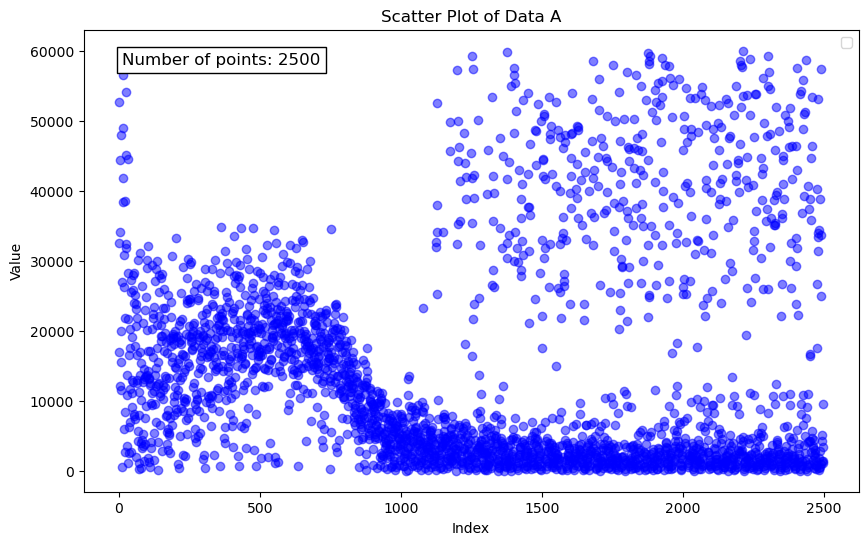

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2500, 1)


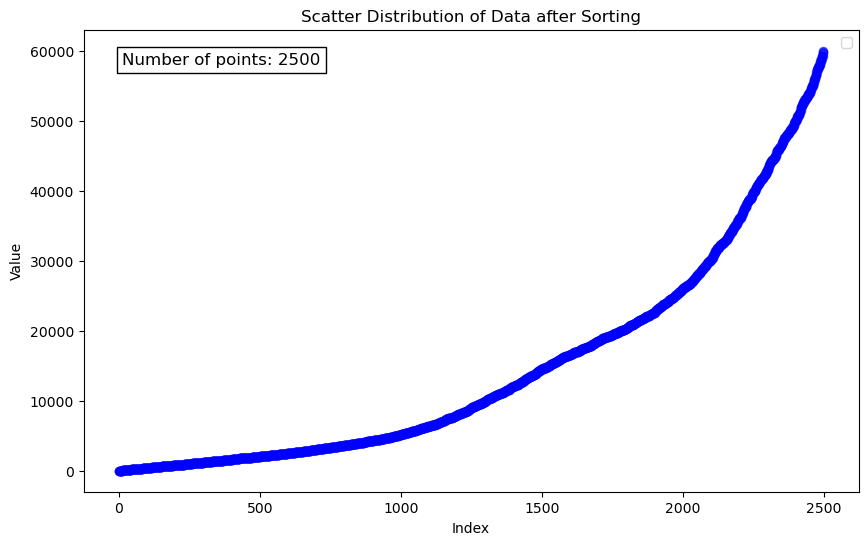

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
# 创建DataFrame
df = pd.DataFrame({'Seed': seeds, 'Error': error_y})

# 将DataFrame保存到CSV文件
df.to_csv('seeds_and_errors_residual.csv', index=False)

print("数据已保存到seeds_and_errors.csv文件中")

数据已保存到seeds_and_errors.csv文件中


In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.04814072619586338, 0.050482698993388954, 0.0434676730020645, 0.04215738004135044, 0.051940301173569174, 0.045114062346978866, 0.06350813110564744, 0.04833664280680596, 0.04102440220410148, 0.046406700061332365, 0.054487478995951945, 0.07135240847275379, 0.06088487749966162, 0.04919797841291723, 0.04318191155677445, 0.05541865739610239, 0.05024447728476989, 0.056268143278921524, 0.052325023000858756, 0.061610302491940716, 0.04838822716119639, 0.07056755455733278, 0.04716790984020015, 0.050818009444700295, 0.0506907841555433, 0.054476921930771006, 0.042461750214506384, 0.053149418412300774, 0.055074948921677365, 0.04643040898404724, 0.04773631880396815, 0.04805578741924181, 0.04362521591574522, 0.05125556532188876, 0.044318743003986555, 0.05070460323773454, 0.04895847624553854, 0.04588359202774735, 0.04903007954420228, 0.04673674872223793, 0.04486779380616016, 0.04861020306668553, 0.0541596697262352, 0.05567697311956446, 0.051994149294870916, 0.06594426578686839, 0.05169599835111989, 

[0.04814072619586338, 0.050482698993388954, 0.0434676730020645, 0.04215738004135044, 0.051940301173569174, 0.045114062346978866, 0.06350813110564744, 0.04833664280680596, 0.04102440220410148, 0.046406700061332365, 0.054487478995951945, 0.07135240847275379, 0.06088487749966162, 0.04919797841291723, 0.04318191155677445, 0.05541865739610239, 0.05024447728476989, 0.056268143278921524, 0.052325023000858756, 0.061610302491940716, 0.04838822716119639, 0.07056755455733278, 0.04716790984020015, 0.050818009444700295, 0.0506907841555433, 0.054476921930771006, 0.042461750214506384, 0.053149418412300774, 0.055074948921677365, 0.04643040898404724, 0.04773631880396815, 0.04805578741924181, 0.04362521591574522, 0.05125556532188876, 0.044318743003986555, 0.05070460323773454, 0.04895847624553854, 0.04588359202774735, 0.04903007954420228, 0.04673674872223793, 0.04486779380616016, 0.04861020306668553, 0.0541596697262352, 0.05567697311956446, 0.051994149294870916, 0.06594426578686839, 0.05169599835111989, 

/tmp/ipykernel_1811981/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


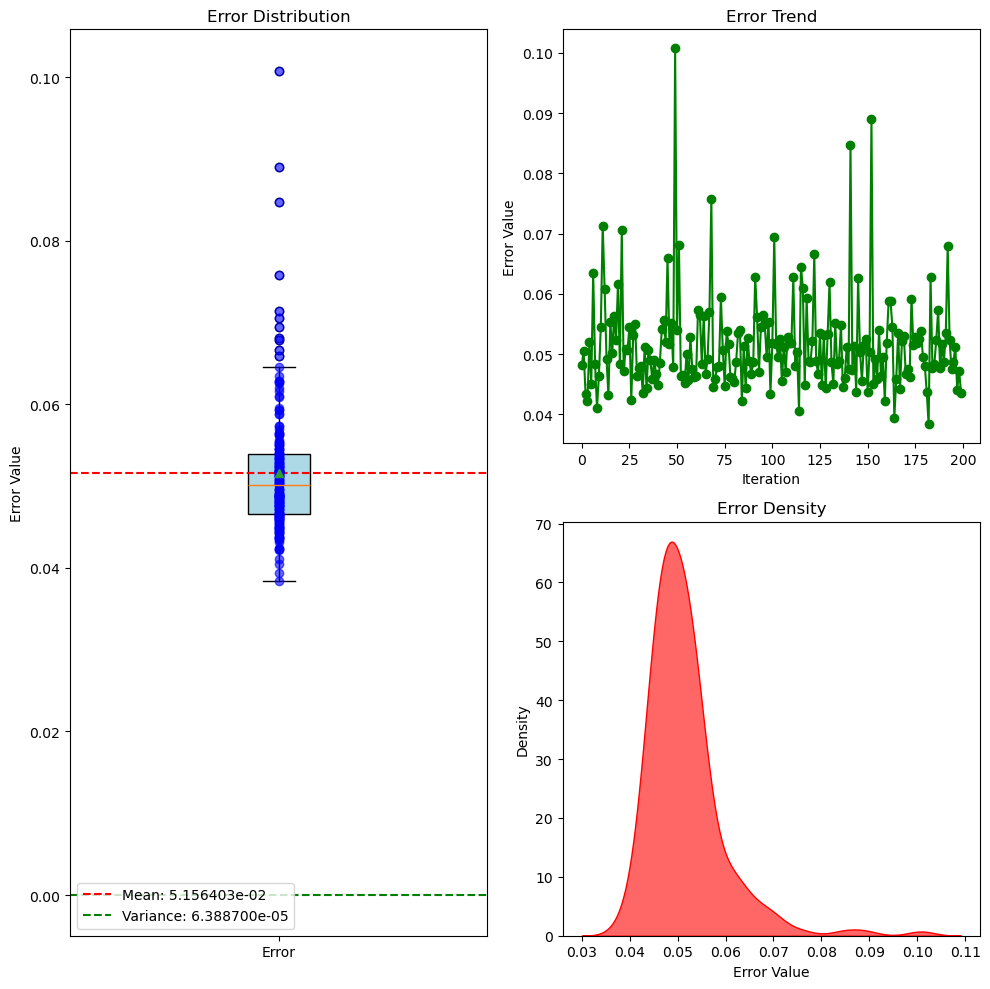

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.02284289279664399, 0.026266489133547045, 0.02321181411763901, 0.02139457992816092, 0.025149914587123925, 0.023875757829415672, 0.02979720361680571, 0.023815370547214353, 0.02123112405364841, 0.022521923689025895, 0.028258778317275142, 0.03172656294280677, 0.029436280998156653, 0.022746855048325777, 0.021701934061189275, 0.02707792180516674, 0.022066209654319633, 0.026265798875858164, 0.026411994228368173, 0.028166787613331575, 0.024155906599653196, 0.031221175307809292, 0.02366348777313892, 0.025271622470087657, 0.025530276945600432, 0.027529890158003764, 0.018044069376977397, 0.025719556527744596, 0.026558437723721514, 0.024303750484187158, 0.02266130734472252, 0.022937205652864636, 0.02192373295219738, 0.024592549842737114, 0.023356590740429433, 0.026248753721703655, 0.02496323377460057, 0.02268708174632028, 0.022498150404492934, 0.024135575464836977, 0.021887761282856404, 0.023760374528387935, 0.026277581351962412, 0.02720941180018282, 0.025111655165903, 0.030527790754716004, 0.0

/tmp/ipykernel_1811981/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


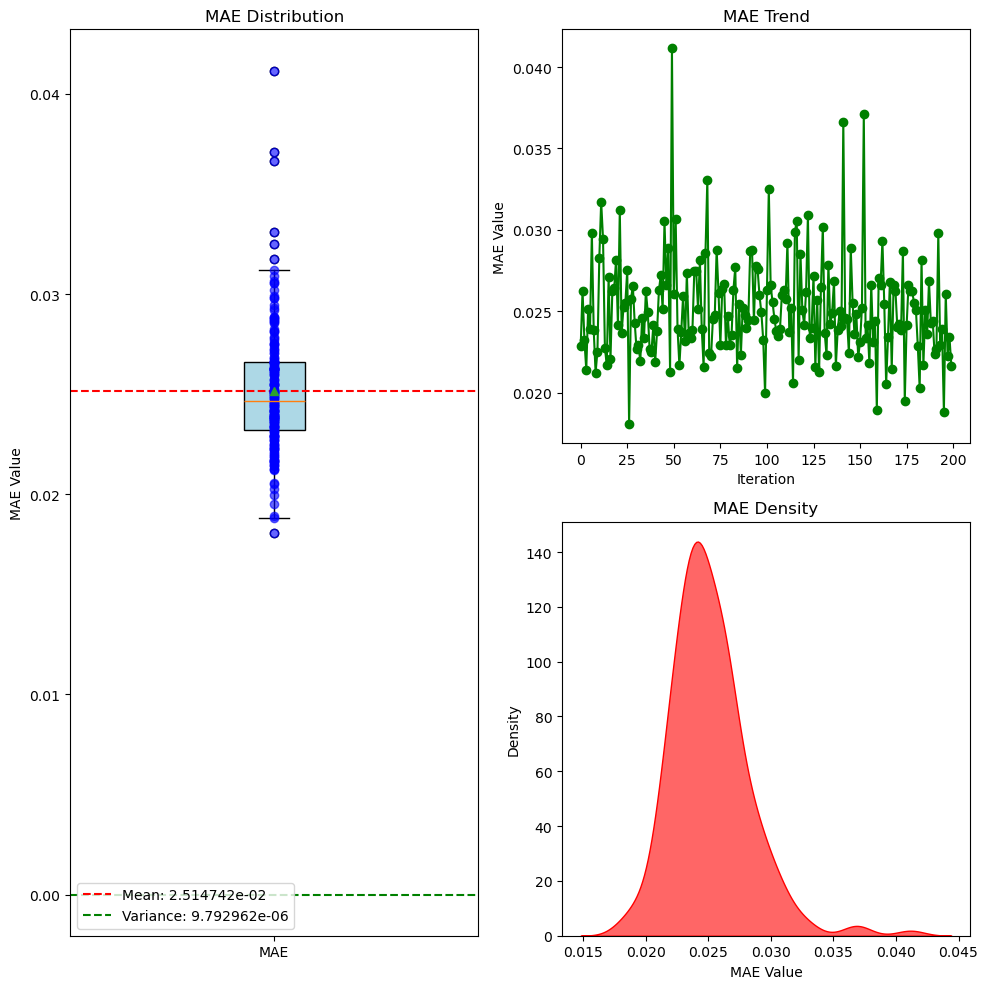

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0009133389670326503, 0.0010944724521683457, 0.0008514310896499519, 0.0007571098258046732, 0.0011794541599294047, 0.0008920096624688835, 0.0013580234076738138, 0.000988228679359004, 0.0007462563940262685, 0.0008812057039099066, 0.0012525853268995973, 0.0015772346668930836, 0.0013427832522135577, 0.0009859927528150952, 0.0007861732404281288, 0.0012573328646950286, 0.0009410582984698482, 0.0011552184733363575, 0.0010813217586148724, 0.001254179042521068, 0.0010185909805907542, 0.001621200924078771, 0.0009408050418396269, 0.0009914866808983505, 0.0011249339526004452, 0.0013125920185157952, 0.0006550357721764638, 0.0012011980745914646, 0.0013203958277705182, 0.0009838501941033437, 0.0008971644374404001, 0.0009573128056840007, 0.0008457199464547254, 0.0011148669237302296, 0.0008641169727533873, 0.0011245540631561047, 0.000989044090512962, 0.0008898027255418472, 0.0009374492582476238, 0.0009463576335019292, 0.00083289625342553, 0.0010144119781662173, 0.0011041714270507172, 0.00123796732857

/tmp/ipykernel_1811981/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


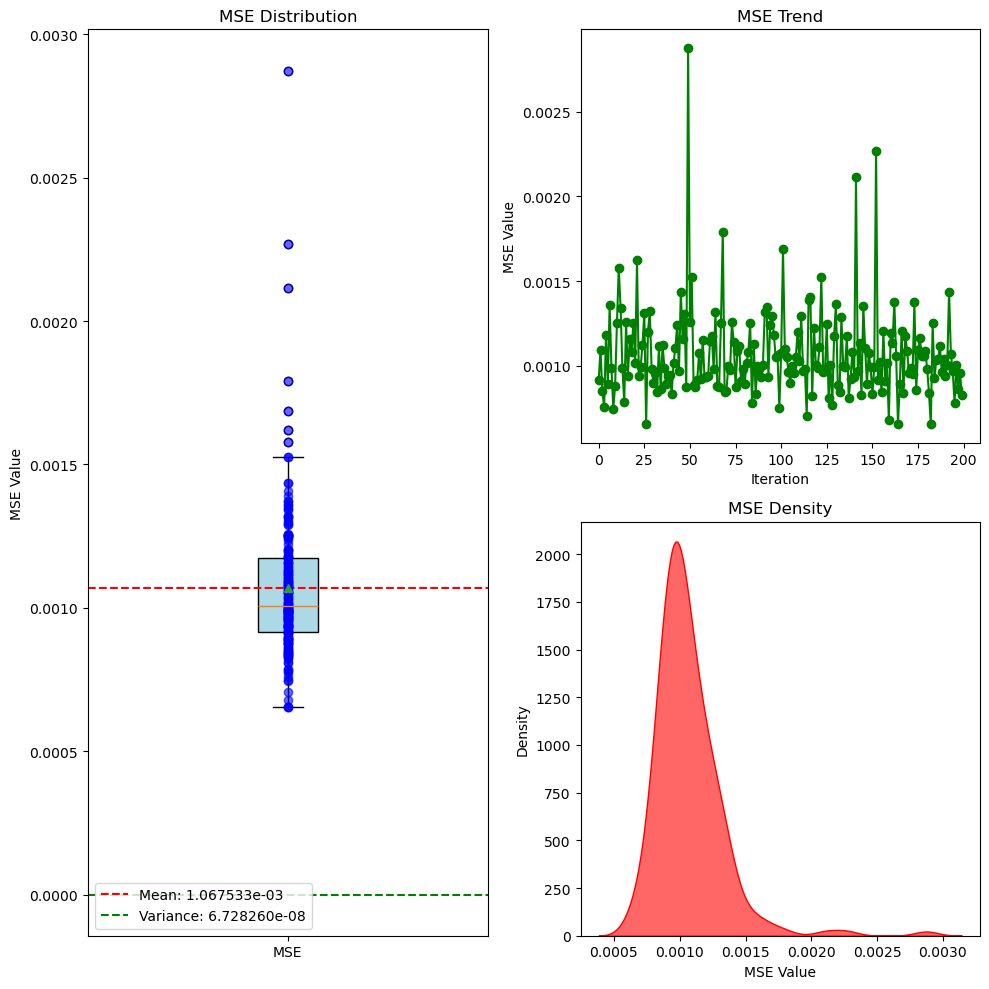

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[121.66722, 0.002765967, 3089.455, 9376.304, 0.00396076, 8.285835, 19395.684, 9457.398, 0.72703063, 0.0017688206, 0.0015692187, 3496.7144, 0.0010586292, 0.0016632361, 0.92673963, 2.0223439, 0.39475587, 0.0027348585, 32.23526, 4.179978, 168.6785, 0.3864121, 0.0063716047, 24.593678, 907.4107, 23958.963, 0.0015848528, 3000.814, 25853.14, 1.1742454, 1.1661549, 0.0022559161, 0.003081026, 5.567293, 262.05188, 0.038978666, 0.2806757, 0.0016235195, 753.05396, 846.234, 0.0014372184, 873.4121, 3155.0752, 3.2446494, 32534.445, 3.2725859, 0.0014674182, 0.81184393, 72.96678, 0.043359146, 46779.76, 12.483216, 85.57127, 105.467094, 448.17886, 25399.0, 0.0019351011, 3.603207, 0.1332542, 6.165942, 725.6688, 0.0015945579, 0.0026592342, 38058.0, 24.035784, 0.0014963414, 117.44372, 1289.7291, 1.4877131, 20.165066, 388.8376, 947.98315, 478.6508, 40.461197, 298.05524, 0.0024455115, 0.0011409855, 0.0018726324, 6.284704, 0.021545045, 0.2834844, 11.474087, 7.684594, 0.0016995511, 0.001905054, 13.277492, 0.0042

/tmp/ipykernel_1811981/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


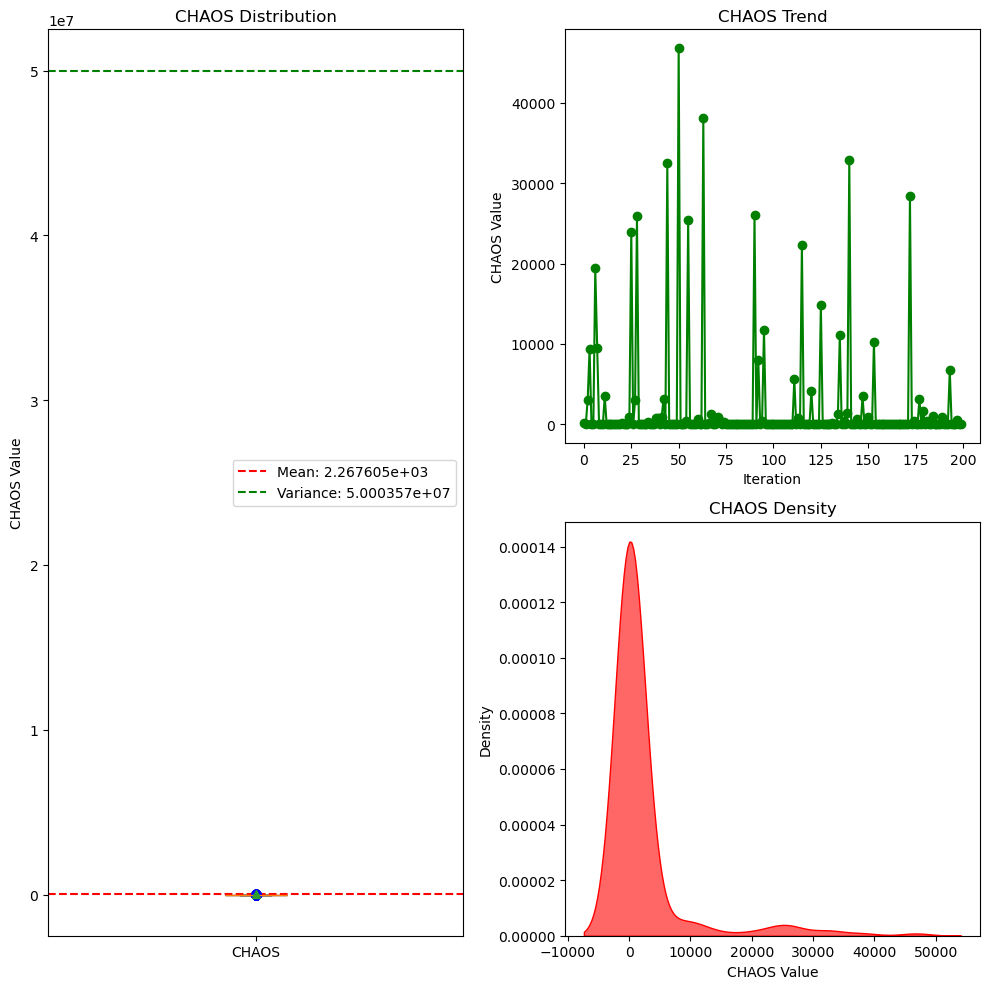

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.406319e-08, 3.4037498e-08, 3.14908e-08, 3.198653e-08, 3.5922994e-08, 3.263358e-08, 2.6302587e-08, 3.602554e-08, 3.098637e-08, 3.4743834e-08, 3.457285e-08, 2.7676492e-08, 2.995432e-08, 3.3120386e-08, 3.1918034e-08, 3.382661e-08, 3.5534413e-08, 3.015066e-08, 3.1116315e-08, 2.7777446e-08, 3.3931883e-08, 3.0153387e-08, 3.0983983e-08, 2.9995135e-08, 3.2078106e-08, 3.543687e-08, 3.875209e-08, 3.5895482e-08, 3.770674e-08, 3.5039648e-08, 3.4302275e-08, 3.1251375e-08, 3.2723847e-08, 3.4654477e-08, 3.2778416e-08, 3.490618e-08, 3.3525225e-08, 3.2496928e-08, 3.6227902e-08, 3.2858907e-08, 3.4566597e-08, 3.4162895e-08, 3.00779e-08, 3.4219966e-08, 3.0563285e-08, 2.940385e-08, 3.4115374e-08, 3.295554e-08, 3.295395e-08, 2.6656267e-08, 3.52627e-08, 2.8296654e-08, 3.1906666e-08, 3.8181724e-08, 3.380228e-08, 3.1472155e-08, 3.2174512e-08, 3.1234094e-08, 3.1917352e-08, 3.518562e-08, 3.457103e-08, 2.8337979e-08, 2.9019589e-08, 3.3237257e-08, 3.1559466e-08, 3.135915e-08, 4.1870862e-08, 3.107698e-08, 2.9497

/tmp/ipykernel_1811981/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


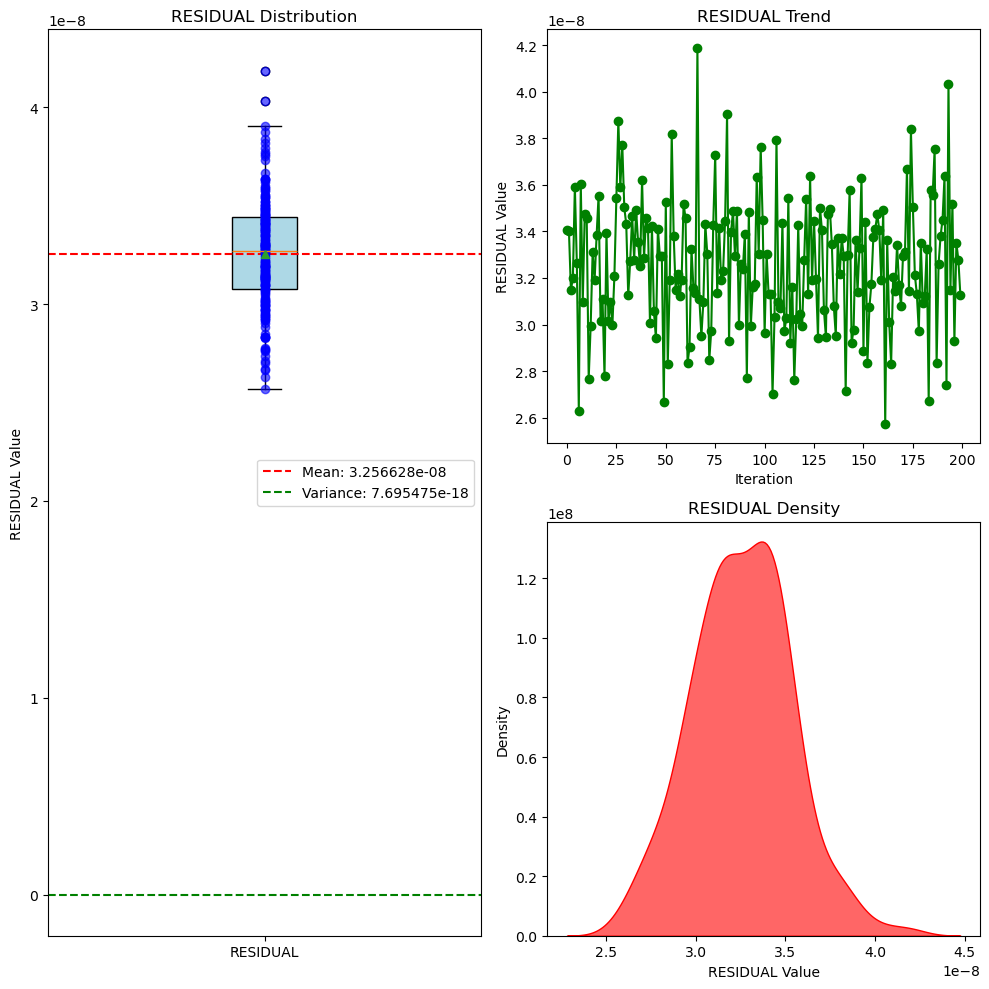

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[2.3291256e+00 2.1146450e+00 1.9014957e+00 ... 2.5236742e-09 2.5236346e-09
 2.5235938e-09]


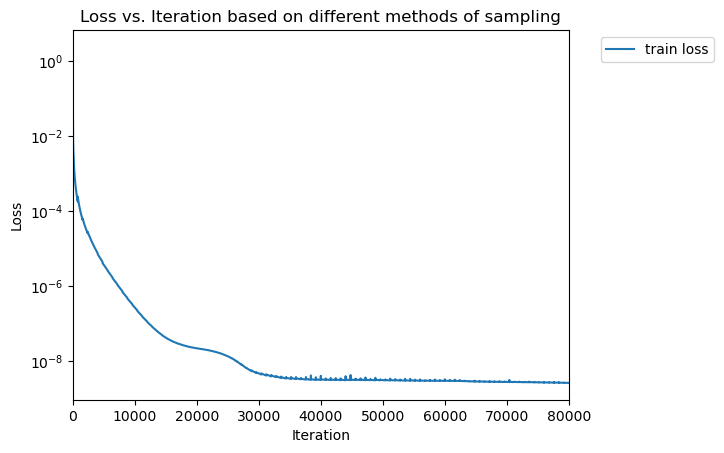

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

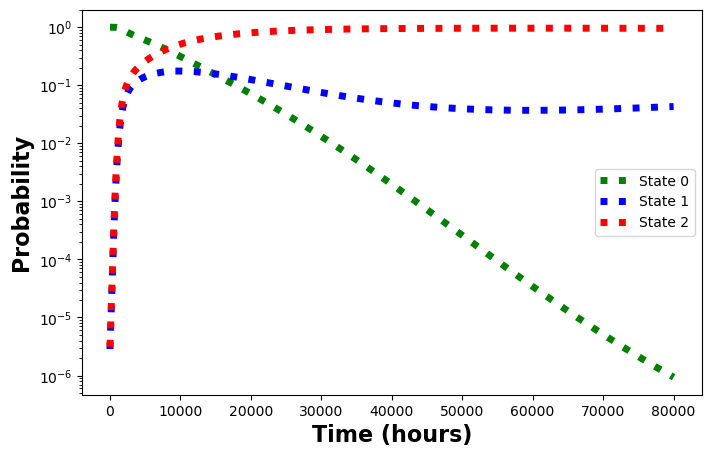

In [19]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

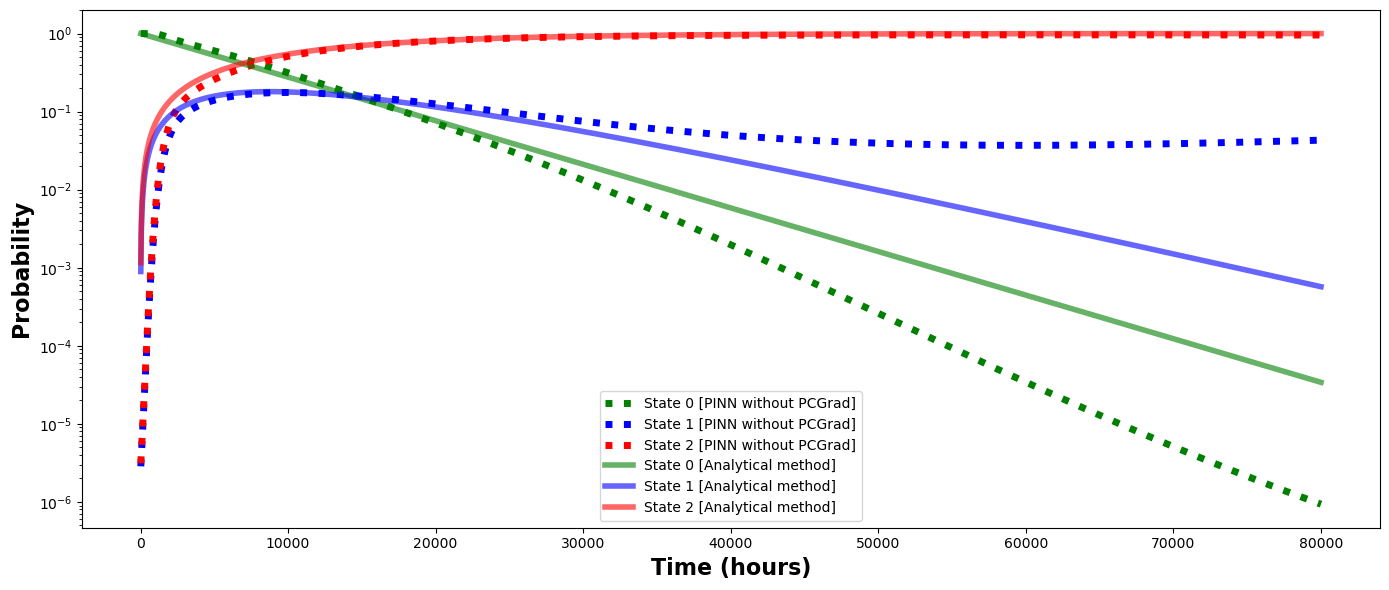

In [20]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=eigenvector_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [21]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999994  0.000003  0.000003
1  0.999993  0.000003  0.000004
2  0.999992  0.000004  0.000004
3  0.999991  0.000004  0.000005
4  0.999989  0.000005  0.000006
           state_0   state_1   state_2
4995  9.450078e-07  0.043024  0.956975
4996  9.426173e-07  0.043032  0.956967
4997  9.402327e-07  0.043041  0.956958
4998  9.378534e-07  0.043049  0.956950
4999  9.354835e-07  0.043057  0.956942


In [22]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [23]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

In [24]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_eigenvectors['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.043444408685266354
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.040298188919728785
RMSE between PINN without PCGrad and the analytical solution after 60000 is 0.052873008126513646


### 计算混沌度和残差

In [25]:
x_star.shape

(5000, 1)

In [26]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(1000, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[3.1241396e-07 3.2623421e-07 2.8672639e-07 ... 3.0220806e-07 2.8120391e-07
 3.2708388e-07]
(5000,)
292.41736


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 1.3824319e-10 -6.5483619e-11 -1.8189894e-10 ...  9.0949470e-13
  3.6379788e-12 -4.5474735e-13]
(5000,)
-4.570211e-10
